# TextGrad Tutorials: MultiModal Optimization

![TextGrad](https://github.com/vinid/data/blob/master/logo_full.png?raw=true)

An autograd engine -- for textual gradients!

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/zou-group/TextGrad/blob/main/examples/notebooks/Prompt-Optimization.ipynb)
[![GitHub license](https://img.shields.io/badge/License-MIT-blue.svg)](https://lbesson.mit-license.org/)
[![Arxiv](https://img.shields.io/badge/arXiv-2406.07496-B31B1B.svg)](https://arxiv.org/abs/2406.07496)
[![Documentation Status](https://readthedocs.org/projects/textgrad/badge/?version=latest)](https://textgrad.readthedocs.io/en/latest/?badge=latest)
[![PyPI - Python Version](https://img.shields.io/pypi/pyversions/textgrad)](https://pypi.org/project/textgrad/)
[![PyPI](https://img.shields.io/pypi/v/textgrad)](https://pypi.org/project/textgrad/)

**Objectives for this tutorial:**

* Introduce you to multimodal optimization with TextGrad

**Requirements:**

* You need to have an OpenAI API key to run this tutorial. This should be set as an environment variable as OPENAI_API_KEY.


In [1]:
# Some utils to read images

import io
from PIL import Image

In [2]:
import textgrad as tg

# differently from the past tutorials, we now need a multimodal LLM call instead of a standard one!
from textgrad.autograd import MultimodalLLMCall
from textgrad.loss import ImageQALoss

In [9]:
tg.set_backward_engine("gpt-4o-mini")

# Simply answering questions about images

We now downlaod an image from the web.

In [10]:
import httpx

image_url = "https://upload.wikimedia.org/wikipedia/commons/a/a7/Camponotus_flavomarginatus_ant.jpg"
image_data = httpx.get(image_url).content

As usual, in TextGrad we now have to transform our object of interest into a Variable object. In the previous tutorials, we were doing this with text data, now we are going to do this with Images.

In [11]:
image_variable = tg.Variable(image_data, role_description="image to answer a question about", requires_grad=False)

Let's now ask as question!

In [12]:
question_variable = tg.Variable("What do you see in this image?", role_description="question", requires_grad=False)
response = MultimodalLLMCall("gpt-4o-mini")([image_variable, question_variable])
response

Variable(value=This image shows a close-up of an ant. The ant appears to be black and is standing on a surface, possibly a ground or a floor. The image is highly detailed, showing the ant's body segments, legs, and antennae. The background is blurred, which helps to focus attention on the ant., role=response from the language model, grads=set())

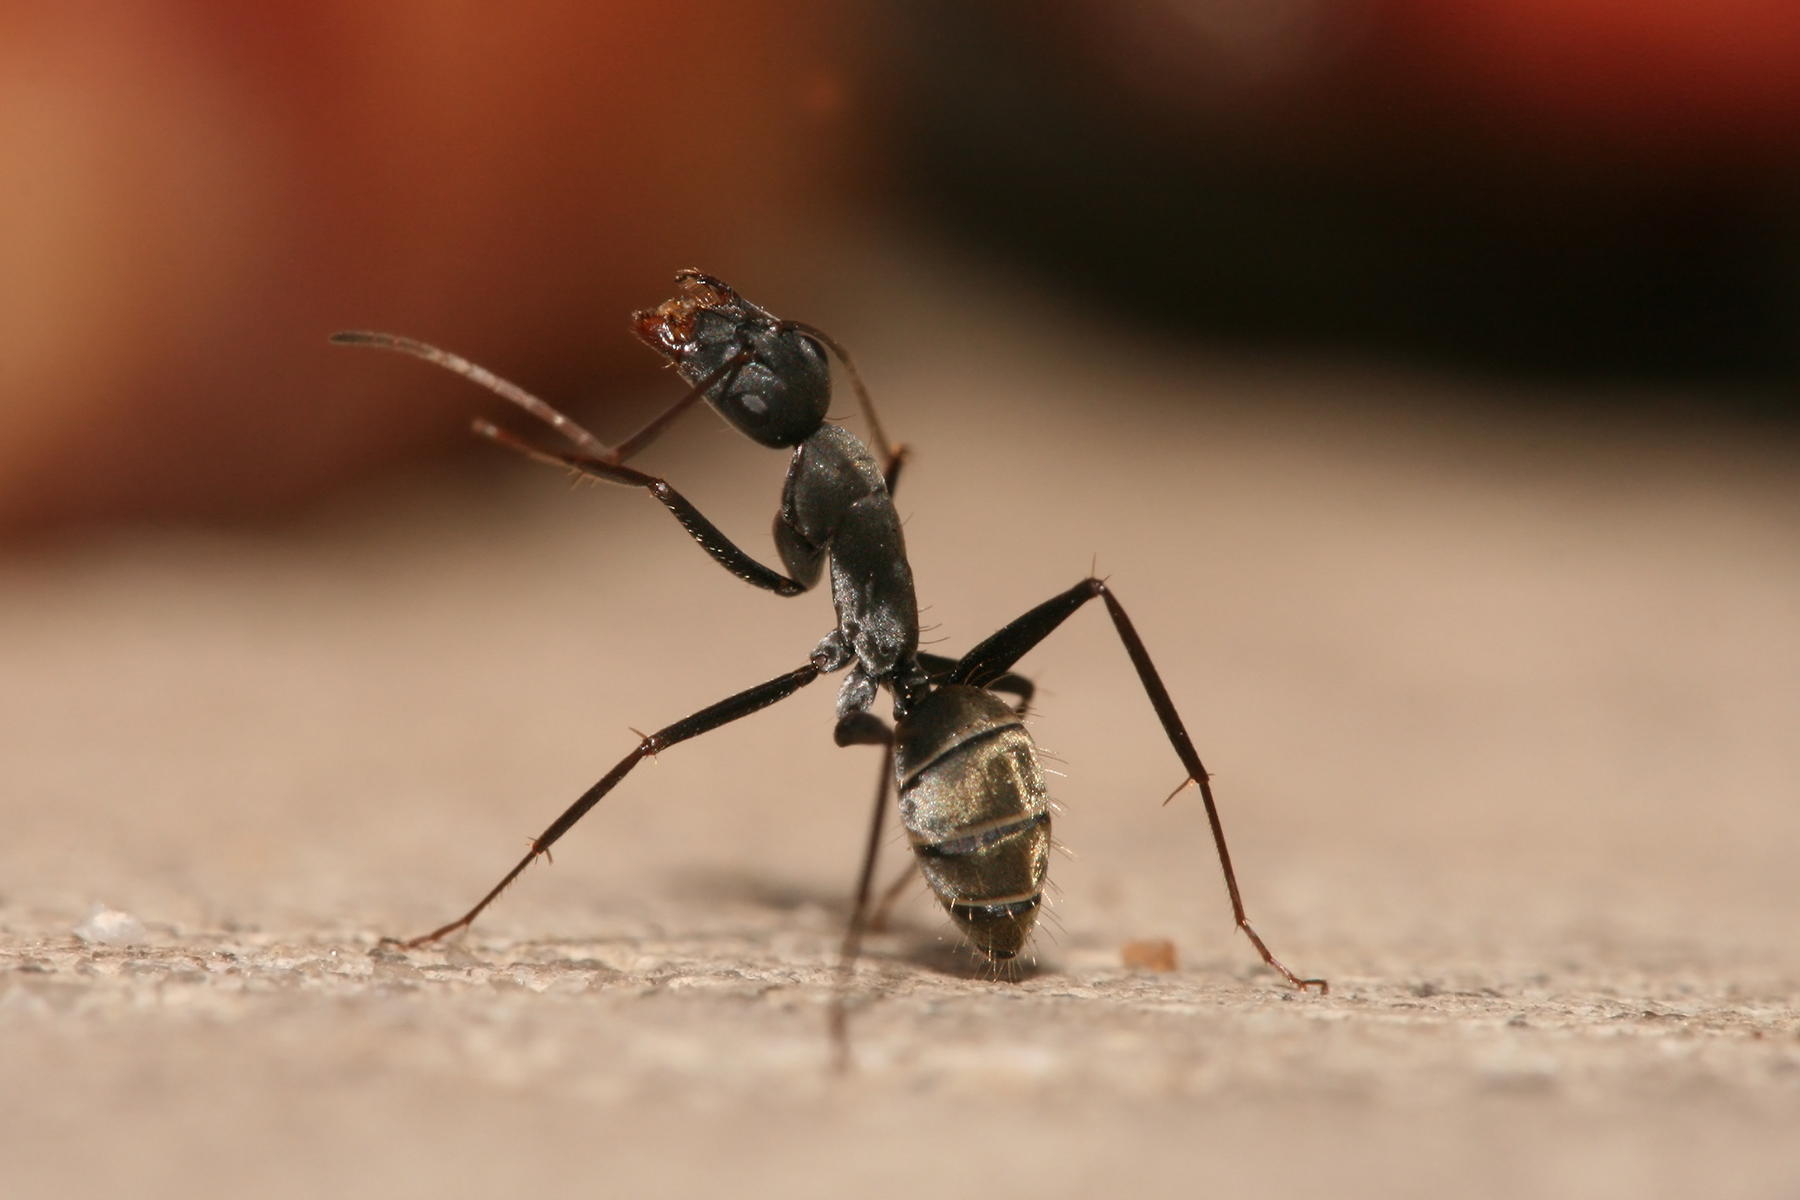

In [93]:
Image.open(io.BytesIO(image_data))

In [15]:
loss_fn = ImageQALoss(
    evaluation_instruction="Does this seem like a complete and good answer for the image? Criticize. Do not provide a new answer.",
    engine="gpt-4o"
)
loss = loss_fn(question=question_variable, image=image_variable, response=response)
loss

Variable(value=The provided answer is quite detailed and covers many aspects of the image. However, there are a few points that could be improved or clarified:

1. **Species Identification**: The answer mentions "likely a species of black ant," which is a bit vague. While it's understandable that the exact species might not be identifiable, it could be better to simply state that it is a black ant without speculating on the species.

2. **Surface Description**: The answer states the ant is on a "textured surface, possibly concrete or soil." This is a reasonable guess, but it could be more concise by just mentioning a textured surface without speculating on the material.

3. **Ant's Posture**: The description of the ant's posture as "alert or defensive" is speculative. While the ant's posture is indeed notable, it might be better to describe it without attributing a specific behavior unless it is clearly evident.

4. **Background Description**: The explanation of the background being bl

In [16]:
optimizer = tg.TGD(parameters=[response])
loss.backward()
optimizer.step()
print(response.value)

This image shows a close-up of a black ant, captured using macro photography. The ant is standing on a textured surface. The image is highly detailed, showcasing the ant's body segments, legs, and antennae with great clarity. The ant's head is raised, and its antennae are extended. The background is blurred, employing a shallow depth of field to focus attention on the ant and highlight its intricate details. The texture of the ant's body segments, the shine on its exoskeleton, and the fine hairs on its legs are all clearly visible, adding to the vividness of the image.
